# Dictionary

**Dataframes**


- **`crashes`, `vehicles`, `people`**: Original datasets.


- **`data`**: The entire raw data after joining `crashes`, `vehicles`, `people`.


- **`modeling_data`**: The subset of `data`, with pre-selected features of `filter list`, before split. 


- **`raw_train`, `raw_test`**: Raw train and test sets by 80/20 split of `modeling_data`:


- **`X_train`, `y_train`, `X_test`, `y_test`**: X and y splits of `raw_train`, `raw_test` respectively, preprocessed by `modeling_data_preprocessor()`.


- **`train`**: `X_train` portion of `data`, with **entire EDA feature set**, preprocessed by `eda_data_preprocessor()`.


---

**Functions**


- **`modeling_data_preprocessor`**: Preprocesses a dataframe and returns X and y ready for modeling (imputation is not included).

    - `X_train, y_train = modeling_data_preprocessor(raw_train)`
    - `X_test, y_test = modeling_data_preprocessor(raw_test)`
     
     
- **`eda_data_preprocessor`**: Preprocesses full data `data` and returns train set for EDA (if you keep or add additional features each time, then further tweaking is still required).

    - `train = eda_data_preprocessor(data)`
   
   
---


**Warnings**

- **Imputation of numerical features** is still required. They are handled **separately** in below cells.


# Packages

In [1]:
# Make sure editing this cell according to your needs
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'pydotplus','bokeh','imblearn', 'catboost'}
missing = required - installedPackages
if missing:
    !pip install researchpy
    !pip install missingno
    !pip install folium
    !pip install pydotplus
    !pip install bokeh
    !pip install imblearn
    !pip install catboost
    #!pip install xgboost
    #!pip install graphviz

#Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno
import itertools
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
import graphviz

from sklearn import tree
from sklearn import feature_selection
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, \
precision_score, recall_score, roc_auc_score, f1_score, precision_recall_curve, auc 

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

# Data Sourcing

In [3]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(path_crashes, parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
                      low_memory=False, dtype=object)
vehicles = pd.read_csv(path_vehicles, parse_dates=["CRASH_DATE"], low_memory=False, dtype=object)
people = pd.read_csv(path_people, parse_dates=["CRASH_DATE"], low_memory=False, dtype=object)

In [4]:
# Joining original datasets
non_passengers=people[people.PERSON_ID.str.contains('^O')]

vehicles_with_people=vehicles.merge(non_passengers,how='left',on=['CRASH_RECORD_ID','RD_NO','CRASH_DATE','VEHICLE_ID'])

data=crashes.merge(vehicles_with_people,how='inner',on=['CRASH_RECORD_ID','RD_NO','CRASH_DATE'])

# Feature Selection
filter_list=["AGE","LANE_CNT","AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","POSTED_SPEED_LIMIT","NUM_UNITS","TRAFFICWAY_TYPE",  
             "SEC_CONTRIBUTORY_CAUSE","FIRST_CRASH_TYPE","MOST_SEVERE_INJURY","LIGHTING_CONDITION","SEX","CRASH_DATE",
             "CRASH_HOUR","VEHICLE_YEAR"]

# Data that will be used in modeling
modeling_data=data[filter_list]

In [5]:
# Split modeling data into raw train and test sets
raw_train, raw_test = train_test_split(modeling_data, test_size=0.20, random_state=42, shuffle=True)

# Data Preprocessing

## Function Definitions

### `modeling_data_preprocessor()`

In [6]:
def modeling_data_preprocessor(dataframe):
    '''Preprocesses df and returns X and y ready for modeling (after imputation of numericals!)'''
    df = dataframe.copy()
    
    # Prepare data for missing value imputation
    df.loc[df["LIGHTING_CONDITION"] == "UNKNOWN", "LIGHTING_CONDITION"] = np.nan
    df.loc[df["TRAFFICWAY_TYPE"] == "UNKNOWN","TRAFFICWAY_TYPE"] = np.nan
    df.loc[df["AIRBAG_DEPLOYED"] == "DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"] = np.nan
    df.fillna({'LIGHTING_CONDITION': 'DAYLIGHT', 'TRAFFICWAY_TYPE': 'NOT DIVIDED',
               'SEX': 'UNABLE TO DETERMINE', 'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE'}, inplace=True)
    
    # Remove rows missing most severe injury results
    drop_rows = ['MOST_SEVERE_INJURY']
    df.dropna(how ='any', subset = drop_rows, inplace = True)
    
    # Handle numerical features
    df['VEHICLE_YEAR'] = pd.to_numeric(df['VEHICLE_YEAR'])
    df['NUM_UNITS'] = pd.to_numeric(df['NUM_UNITS'])
    df["POSTED_SPEED_LIMIT"] = pd.to_numeric(df["POSTED_SPEED_LIMIT"])
    df["AGE"] = pd.to_numeric(df["AGE"])
    
    df['LANE_CNT'] = pd.to_numeric(df['LANE_CNT'])    
    df['LANE_CNT'].fillna(2, inplace=True)
    df.loc[(df['LANE_CNT'] > 6),'LANE_CNT'] = 6
    
    # Function definitions
    def injury(x): 
        if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
            return "INJURED"
        else:
            return "NOT INJURED"
    
    def airbag(x):
        if ("DEPLOY" in x) and ("UNKNOWN" not in x):
            if "NOT" in x:
                return "NOT DEPLOYED"
            else:
                return "DEPLOYED"
        else:
            return x

    def crash_hour(x):
        if  2 <= x < 8:
            return "Early_morning"
        elif 8 <= x < 12:
            return "Morning"
        elif 12 <= x < 18:
            return "Afternoon"
        else:
            return "Night"
  
    def traffic_way(x):
        if ("NOT" in x) or ("ONE-WAY" in x):
            return "NOT_DIVIDED"
        else:
            return "DIVIDED"
    
    # Feature Engineering
    df["INJURY"] = df["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
    df["AIRBAG_DEPLOYED"] = df["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))
    df["CRASH_HOUR"] = df["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))
    df["TRAFFICWAY_TYPE"] = df["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))
    
    df["VEHICLE_AGE"] = df["CRASH_DATE"].dt.year-df["VEHICLE_YEAR"]
    df.loc[df["VEHICLE_AGE"] < 0, "VEHICLE_AGE"] = 0
    df.drop(["VEHICLE_YEAR", "CRASH_DATE", "MOST_SEVERE_INJURY"], axis=1, inplace=True)
    
    # Splitting df into X and y
    y = df["INJURY"]
    X = df.drop(["INJURY"], axis=1)
    
    # Binarize y
    from sklearn.preprocessing import label_binarize
    y = preprocessing.label_binarize(y, classes=['NOT INJURED', 'INJURED'])
    
    # One-Hot Encoding
    X = pd.get_dummies(X, columns = X.select_dtypes(['object']).columns)
    dummies_to_drop = X.columns[X.columns.str.contains("UNABLE|UNKNOWN|NOT APPLICABLE|OTHER")]
    X = X.loc[:, ~X.columns.isin(dummies_to_drop)]
      
    return(X, y)

### `eda_data_preprocessor()`

In [7]:
def eda_data_preprocessor(dataframe=data):
    '''Preprocesses and returns the entire train set for EDA'''
    
    df = dataframe.copy()
    
    # Split data into train test with exact indexing
    train, test = train_test_split(df, test_size=0.20, random_state=42, shuffle=True)
    
    # Feature reduction
    drop=["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", "DATE_POLICE_NOTIFIED",
          "BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", 
          "INJURIES_NO_INDICATION", "INJURIES_UNKNOWN", "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "RD_NO", "VEHICLE_ID", 
          "CRASH_RECORD_ID", "SEAT_NO", "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", "PERSON_ID", "DRIVERS_LICENSE_CLASS", 
          "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", "EMS_RUN_NO", "PEDPEDAL_LOCATION", "LOCATION",
          "DAMAGE", "CRASH_TYPE", "MODEL", "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", 
          "VEHICLE_ID", "CMRC_VEH_I", "MAKE", "TOWED_I", "FIRE_I", "TOWED_BY", "STREET_NO","STREET_NAME",
          "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", "AREA_05_I", "AREA_06_I", 
          "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", 
          "USDOT_NO", "CCMC_NO", "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", 
          "CARRIER_CITY", "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
          "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", "MCS_VIO_CAUSE_CRASH_I", 
          "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", 
          "TOTAL_VEHICLE_LENGTH", "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
          "INJURIES_REPORTED_NOT_EVIDENT", "INJURIES_NON_INCAPACITATING", #"INJURIES_FATAL","INJURIES_INCAPACITATING",
          "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"]
    
    train = train.loc[:, ~train.columns.isin(drop)]
    
    
    # Prepare data for missing value imputation
    train.loc[train["TRAFFIC_CONTROL_DEVICE"]=="UNKNOWN","TRAFFIC_CONTROL_DEVICE"]=np.nan
    train.loc[train["DEVICE_CONDITION"]=="UNKNOWN","DEVICE_CONDITION"]=np.nan
    train.loc[train["WEATHER_CONDITION"]=="UNKNOWN","WEATHER_CONDITION"]=np.nan
    train.loc[train["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
    train.loc[train["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
    train.loc[train["ROADWAY_SURFACE_COND"]=="UNKNOWN","ROADWAY_SURFACE_COND"]=np.nan
    train.loc[train["ROAD_DEFECT"]=="UNKNOWN","ROAD_DEFECT"]=np.nan

    train.loc[train["VEHICLE_DEFECT"]=="UNKNOWN","VEHICLE_DEFECT"]=np.nan
    train.loc[train["VEHICLE_TYPE"]=="UNKNOWN/NA","VEHICLE_TYPE"]=np.nan
    train.loc[train["TRAVEL_DIRECTION"]=="UNKNOWN","TRAVEL_DIRECTION"]=np.nan
    train.loc[train["MANEUVER"]=="UNKNOWN/NA","MANEUVER"]=np.nan

    train.loc[train["SAFETY_EQUIPMENT"]=="USAGE UNKNOWN","SAFETY_EQUIPMENT"]=np.nan
    train.loc[train["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan
    train.loc[train["EJECTION"]=="UNKNOWN","EJECTION"]=np.nan
    train.loc[train["DRIVER_ACTION"]=="UNKNOWN","DRIVER_ACTION"]=np.nan
    train.loc[train["DRIVER_VISION"]=="UNKNOWN","DRIVER_VISION"]=np.nan
    train.loc[train["PHYSICAL_CONDITION"]=="UNKNOWN","PHYSICAL_CONDITION"]=np.nan
    train.loc[train["PEDPEDAL_ACTION"]=="UNKNOWN/NA","PEDPEDAL_ACTION"]=np.nan
    
    
    # Mıssing Value Imputation
    train.fillna({
        'TRAFFIC_CONTROL_DEVICE': 'NO CONTROLS',
        'DEVICE_CONDITION': 'NO CONTROLS',
        'WEATHER_CONDITION': 'CLEAR',
        'LIGHTING_CONDITION': 'DAYLIGHT', # ??
        'TRAFFICWAY_TYPE': 'NOT DIVIDED', # ??
        'ROADWAY_SURFACE_COND': 'NO DEFECTS',
        'ROAD_DEFECT': 'CLEAR',
        'INTERSECTION_RELATED_I': 'N',
    
        'NOT_RIGHT_OF_WAY_I': 'N',
        'HIT_AND_RUN_I': 'N',
        'DOORING_I': 'N',
        'WORK_ZONE_I': 'N',
        'NUM_PASSENGERS': 0,
        'LIC_PLATE_STATE': 'IL',
        'VEHICLE_DEFECT': 'UNABLE TO DETERMINE',
        'VEHICLE_TYPE': 'OTHER',

        'VEHICLE_USE': 'OTHER',
        'TRAVEL_DIRECTION': 'N',
        'MANEUVER': 'OTHER',
        'OCCUPANT_CNT': 0,
        'EXCEED_SPEED_LIMIT_I': 'N',
        'FIRST_CONTACT_POINT': 'OTHER',
        'PERSON_TYPE': 'UNABLE TO DETERMINE',
        'CITY': 'OTHER',

        'SEX': 'UNABLE TO DETERMINE',
        'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
        'EJECTION': 'UNABLE TO DETERMINE',
        'DRIVER_ACTION': 'OTHER',
        'DRIVER_VISION': 'OTHER',
        'PHYSICAL_CONDITION': 'UNABLE TO DETERMINE',
        'PEDPEDAL_ACTION': 'UNABLE TO DETERMINE',
        'PEDPEDAL_VISIBILITY': 'UNABLE TO DETERMINE',

        'CELL_PHONE_USE': 'UNABLE TO DETERMINE',
        'SAFETY_EQUIPMENT': 'UNABLE TO DETERMINE',
        'BAC_RESULT VALUE': 0
    }, inplace=True)
    
    
    # Drop rows with missing values in these features
    drop_rows = ['INJURIES_TOTAL', 'LATITUDE', 'MOST_SEVERE_INJURY']
    train.dropna(how = 'any', subset = drop_rows, inplace = True)
    

    # Handle numerical features
    train['LANE_CNT'] = pd.to_numeric(train['LANE_CNT'])
    train['VEHICLE_YEAR'] = pd.to_numeric(train['VEHICLE_YEAR'])
    train['NUM_UNITS'] = pd.to_numeric(train['NUM_UNITS'])
    train["POSTED_SPEED_LIMIT"] = pd.to_numeric(train["POSTED_SPEED_LIMIT"])
    train["AGE"] = pd.to_numeric(train["AGE"])
    train["INJURIES_FATAL"] = pd.to_numeric(train["INJURIES_FATAL"])
    train["INJURIES_INCAPACITATING"] = pd.to_numeric(train["INJURIES_INCAPACITATING"])
    train["INJURIES_TOTAL"] = pd.to_numeric(train["INJURIES_TOTAL"])
    
    train['TOTAL_FATAL'] = train['INJURIES_FATAL'] + train['INJURIES_INCAPACITATING']
    train['TOTAL_FATAL'] = pd.to_numeric(train['TOTAL_FATAL'])

    train['LANE_CNT'] = pd.to_numeric(train['LANE_CNT'])    
    train['LANE_CNT'].fillna(2, inplace=True)
    train.loc[(train['LANE_CNT'] > 6),'LANE_CNT'] = 6
    
    
    # Function definitions
    def injury(x): 
        if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
            return "INJURED"
        else:
            return "NOT INJURED"
        
    def fatalities(x): 
        if any(s in x for s in ["FATAL"]):
            return "FATAL"
        else:
            return "NOT FATAL"
    
    def airbag(x):
        if ("DEPLOY" in x) and ("UNKNOWN" not in x):
            if "NOT" in x:
                return "NOT DEPLOYED"
            else:
                return "DEPLOYED"
        else:
            return x
  
    def traffic_way(x):
        if ("NOT" in x) or ("ONE-WAY" in x):
            return "NOT_DIVIDED"
        else:
            return "DIVIDED"
        
    def contact_point(x):
        if "FRONT" in x:
            return "FRONT"
        elif "SIDE" in x:
            return "SIDE"
        elif "REAR" in x:
            return "REAR"
        else:
            return "OTHER"
    
    def equip_used(x):
        if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
            if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
                return "DID NOT USE SAFETY EQUIP"
            else:
                return "USED SAFETY EQUIP"
        else:
            return x

    def airbag(x):
        if ("DEPLOY" in x) and ("UNKNOWN" not in x):
            if "NOT" in x:
                return "NOT DEPLOYED"
            else:
                return "DEPLOYED"
        else:
            return x
    
    def crash_hour(x):
        if  2 <= x < 8:
            return "Early_morning"
        elif 8 <= x < 12:
            return "Morning"
        elif 12 <= x < 18:
            return "Afternoon"
        else:
            return "Night"

    def traffic_control(x):
        if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
            return "NO_SIGN"
        else:
            return "SIGN"
    
    def location(x1,x2):
        if (41.84 <= float(x1) <= 41.9100064) and (-87.7421459 <= float(x2) <= -87.50):
            return "Downtown"
        else:
            return "Not Downtown"

        
    # Feature engineering
    train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
    train["FATALITIES"] = train["MOST_SEVERE_INJURY"].apply(lambda x: fatalities(x))
    train["AIRBAG_DEPLOYED"] = train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))
    train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))
    train["TRAFFICWAY_TYPE"] = train["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))
    train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))
    train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
    train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)
    train["SAFETY_EQUIPMENT"] = train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))
    train["AIRBAG_DEPLOYED"] = train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))
    train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))
    train["Location"] = train.apply(lambda x: location(x["LATITUDE"], x["LONGITUDE"]), axis = 1)
    
    train["VEHICLE_AGE"] = train["CRASH_DATE"].dt.year-train["VEHICLE_YEAR"]
    train.loc[train["VEHICLE_AGE"] < 0, "VEHICLE_AGE"] = 0
    train.drop(["VEHICLE_YEAR", "MOST_SEVERE_INJURY"], axis=1, inplace=True)  # "CRASH_DATE" for Tony
     
    # Return only train set for EDA purposes     
    return(train)

## Preprocessing Train Set

In [8]:
# Preprocess raw train set
X_train, y_train = modeling_data_preprocessor(raw_train)

In [9]:
# Fit imputer and impute missing values on train set 
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)
df = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_train = df.copy()
X_train = np.round(X_train)

X_train.isna().any().sum()

0

## Preprocessing Test Set

In [10]:
# Preprocess raw test set
X_test, y_test = modeling_data_preprocessor(raw_test)

In [11]:
# Add two trivial features of train set that doesn't exist in test set in order to use pre-fit imputer
X_test["PRIM_CONTRIBUTORY_CAUSE_OBSTRUCTED CROSSWALKS"] = 0
X_test["SEC_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS"] = 0
X_test = X_test[X_train.columns]

# Impute missing values on test set by pre-fit imputer object 
df = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)
X_test = df.copy()
X_test = np.round(X_test)

X_test.isna().any().sum()

0

## Preprocessing EDA Train Set

In [12]:
# X_train portion of `data`, with entire EDA feature set
train = eda_data_preprocessor(data)

# Modeling on Bootstrapped Samples

Suggested before drawing conclusions on model's decisions.

In [13]:
# Random Undersampling on X and y train sets
under = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = under.fit_resample(X_train, y_train)

In [14]:
# Store n_bootstraps number of bootstrapped train & test samples and store X and y for each separately in lists

# This operation is fast regardless of n_bootstraps.  
# But the prediction in the next cell takes ~3.5 mins for 30 and ~10 mins for 100 iterations.
# At least 100 is suggested for achieving a gaussian distribution. 
n_bootstraps = 30

bootstrap_X_train = []
bootstrap_y_train = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(X_under, y_under)
    bootstrap_X_train.append(sample_X)
    bootstrap_y_train.append(sample_y)
    
bootstrap_X_test = []
bootstrap_y_test = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(X_test, y_test)
    bootstrap_X_test.append(sample_X)
    bootstrap_y_test.append(sample_y)

In [15]:
# Random Forest model with tuned hyperparameters
random_final = RandomForestClassifier(n_estimators=1000, min_samples_split=15, min_samples_leaf=5, 
                                      max_features='log2', max_depth=13, criterion='entropy', random_state=0)

# Predict n_bootstraps number of bootstrapped samples and store recall results
recall_scores = []

for index, (train, test) in enumerate(zip(bootstrap_X_train, bootstrap_X_test)):
    model = random_final.fit(train, bootstrap_y_train[index])
    y_pred = model.predict(test)
    recall_scores.append(recall_score(bootstrap_y_test[index], y_pred))

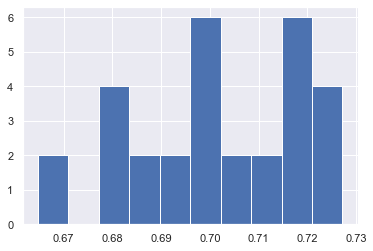

95.0 confidence interval for recall 66.9% and 72.4% across 30 bootstrapped predictions.


In [16]:
# Plot scores
plt.hist(recall_scores) 
plt.show()

# Show confidence intervals
alpha = 0.95
p = ((1.0 - alpha) / 2.0) * 100
lower = max(0.0, np.percentile(recall_scores, p))
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(recall_scores, p))

print('%.1f confidence interval for recall %.1f%% and %.1f%% across %.d bootstrapped predictions.' % (alpha*100, lower*100, upper*100, n_bootstraps))

In [17]:
# elapsed = timeit.default_timer() - start_time
# print('Total runtime is', round(elapsed, 2)/60, 'minutes.')